### 2.8 Визуализация когортного анализа 

Таблицы удержания и другие показатели в когортном анализе можно визуализировать множеством способов. Наиболее подходящие — тепловая карта и линейный график.

#### Тепловая карта

Хитмэп — отличный выбор, если вы хотите сравнить удержание нескольких когорт. Для примера возьмём данные интернет-магазина «Читать не вредно».


In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# загружаем данные
sessions = pd.read_csv('/datasets/sessions.csv')
profiles = pd.read_csv('/datasets/profiles.csv')

# преобразуем данные о времени
profiles['first_ts'] = pd.to_datetime(profiles['first_ts'])
profiles['dt'] = pd.to_datetime(profiles['dt']).dt.date
sessions['session_start'] = pd.to_datetime(sessions['session_start'])

display(profiles.head(5))  # сессии
sessions.head(5)  # профили

,user_id,first_ts,channel,device,region,dt,month,payer
0,10964006,2019-05-12 04:50:17,Yandex,Mac,Germany,2019-05-12,2019-05-01 00:00:00,True
1,12358165,2019-05-10 23:16:24,Yandex,iPhone,United States,2019-05-10,2019-05-01 00:00:00,False
2,12545358,2019-05-05 19:22:46,Organic,Mac,United States,2019-05-05,2019-05-01 00:00:00,False
3,16165560,2019-05-10 20:29:59,Yandex,PC,United States,2019-05-10,2019-05-01 00:00:00,False
4,17733464,2019-05-12 11:08:25,Organic,iPhone,France,2019-05-12,2019-05-01 00:00:00,True


,user_id,region,device,channel,session_duration,session_start
0,94834909438,Germany,iPhone,Yandex,5.417238,2019-05-01 12:59:48
1,142292250445,United States,iPhone,Organic,33.232475,2019-05-01 21:25:00
2,486879489291,United States,Mac,Organic,33.635569,2019-05-01 21:18:40
3,996478278264,Germany,iPhone,Yandex,76.792801,2019-05-01 07:37:52
4,857023407503,United States,Android,Organic,5.976421,2019-05-01 01:35:01


Cнова напишем функцию `get_retention()` и получим треугольную таблицу удержания со всеми данными — без учёта момента и горизонта анализа данных.

In [2]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

# загружаем данные
sessions = pd.read_csv('/datasets/sessions.csv')  # сессии
profiles = pd.read_csv('/datasets/profiles.csv')  # профили

# преобразуем данные о времени
profiles['first_ts'] = pd.to_datetime(profiles['first_ts'])
profiles['dt'] = pd.to_datetime(profiles['dt']).dt.date
sessions['session_start'] = pd.to_datetime(sessions['session_start'])

# функция для расчёта удержания
def get_retention(
    profiles, sessions, observation_date, horizon_days, ignore_horizon=False
):
    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # рассчитываем удержание
    result_grouped = result_raw.pivot_table(
        index=['dt'], columns='lifetime', values='user_id', aggfunc='nunique'
    )
    cohort_sizes = (
        result_raw.groupby('dt')
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'})
    )
    result_grouped = cohort_sizes.merge(
        result_grouped, on='dt', how='left'
    ).fillna(0)
    result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0)

    # исключаем все лайфтаймы, превышающие горизонт анализа
    result_grouped = result_grouped[
        ['cohort_size'] + list(range(horizon_days))
    ]

    # восстанавливаем столбец с размерами когорт
    result_grouped['cohort_size'] = cohort_sizes

    # возвращаем таблицу удержания и сырые данные
    return result_raw, result_grouped

# получаем сырые данные и готовую таблицу
# игнорируем горизонт анализа
retention_raw, retention = get_retention(
    profiles, sessions, datetime(2019, 5, 13).date(), 14, ignore_horizon=True
)

Построим тепловую карту, вызвав метод `heatmap()` из библиотеки Seaborn.

Столбец с размерами когорт хранит выбивающиеся из общего ряда значения — они будут искажать визуализацию. Удалим его во время построения графика методом `drop()`.


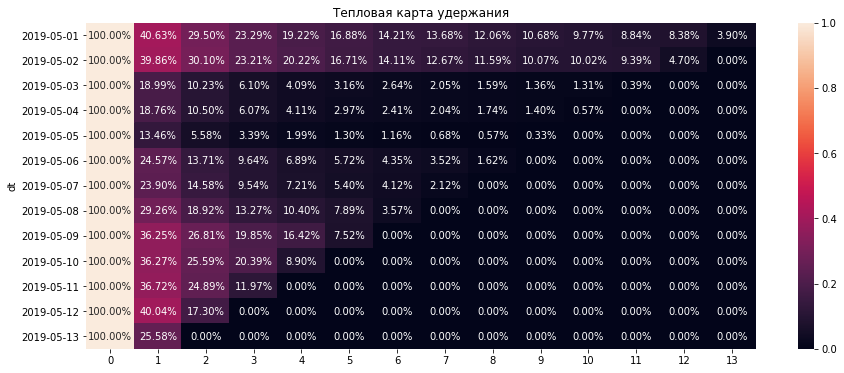

In [3]:
# строим хитмэп

plt.figure(figsize=(15, 6))  # задаём размер графика
sns.heatmap(
    retention.drop(columns=['cohort_size']),  # удаляем размеры когорт
    annot=True,  # включаем подписи
    fmt='.2%',  # переводим значения в проценты
)
plt.title('Тепловая карта удержания')  # название графика
plt.show()

Значения первого дня затмили всю тепловую карту. Retention Rate на нулевой лайфтайм всегда равен единице, поэтому при анализе удержания его часто исключают. Поступим так же, добавив в список удалённых в скобках метода `drop()` столбец `0`.


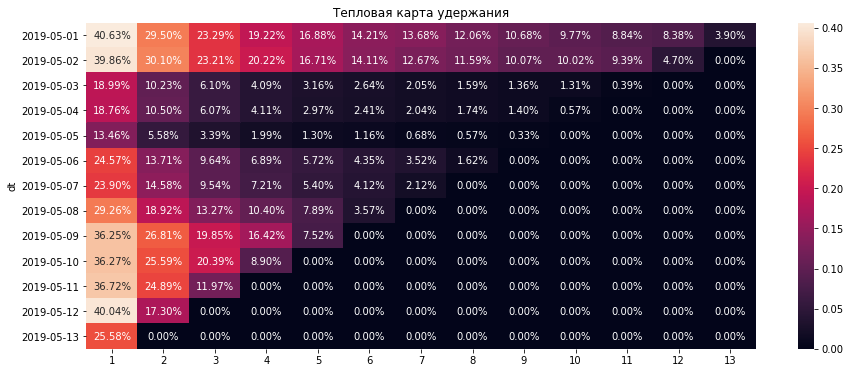

In [4]:
# строим хитмэп без нулевого лайфтайма

plt.figure(figsize=(15, 6))  # задаём размер графика
sns.heatmap(
    retention.drop(columns=['cohort_size', 0]),  # удаляем лишние столбцы
    annot=True,  # включаем подписи
    fmt='.2%',  # переводим значения в проценты
)
plt.title('Тепловая карта удержания')  # название графика
plt.show()

На этом графике намного больше цветов. Тепловая карта стала нагляднее, но ещё есть куда расти: половина графика «залита» чёрным.

Перестанем игнорировать важнейшие параметры когортного анализа. Установим момент анализа на 13 мая, зададим горизонт анализа в 6 дней и передадим параметру `ignore_horizon` значение `False`.

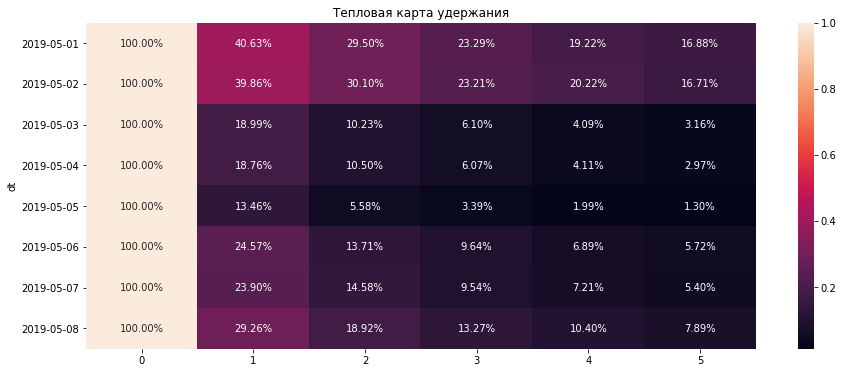

In [5]:
# строим хитмэп с учётом горизонта анализа

retention_raw, retention = get_retention(
    profiles, sessions, datetime(2019, 5, 13).date(), 6
)

plt.figure(figsize = (15, 6))  # задаём размер графика
sns.heatmap(retention.drop(columns = ['cohort_size']), # удаляем размеры когорт
            annot = True,  # включаем подписи
            fmt = '.2%'  # отображаем значения в виде процентов
           )
plt.title('Тепловая карта удержания')  # название графика
plt.show()

Такой хитмэп «рассказывает» гораздо больше. По светлым пятнам на графике видно, что лучшее удержание на второй день показали пользователи, привлечённые 1 мая, а на пятый — привлечённые 2 мая. На шестой день результаты первых двух когорт почти сравнялись: 16,88% против 16,71%.

Показатели остальных когорт не столь радужны: удержание шестого дня составляет менее 8%, а местами падает ниже 3%. Самая «мрачная» когорта на графике — пользователи, привлечённые 5 мая.

#### Кривая удержания

Кривые удержания подходят для «быстрого» сравнения показателей.

Во время знакомства с понятиями Retention Rate и Churn Rate несколькими уроками ранее вы уже наблюдали этот способ визуализации. 

Чтобы построить кривую удержания в Python, применяют метод `plot()`. Он строит график, на котором линии отражают значения каждого столбца датафрейма.

Ещё раз взглянем на таблицу удержания пользователей «Читать не вредно».

In [6]:
retention

,cohort_size,0,1,2,3,4,5
dt,,,,,,,
2019-05-01,10369,1.0,0.406307,0.295014,0.232906,0.192208,0.168772
2019-05-02,8556,1.0,0.398551,0.300958,0.232118,0.202197,0.167134
2019-05-03,9029,1.0,0.189944,0.102337,0.061026,0.040868,0.031565
2019-05-04,11426,1.0,0.187555,0.105024,0.060739,0.041134,0.029669
2019-05-05,11155,1.0,0.134648,0.055760,0.033886,0.019901,0.012999
2019-05-06,11554,1.0,0.245716,0.137095,0.096417,0.068894,0.057210
2019-05-07,9804,1.0,0.238984,0.145757,0.095369,0.072113,0.053958
2019-05-08,8741,1.0,0.292644,0.189223,0.132708,0.103993,0.078938


In [7]:
# удаление столбца cohort_size и транспонирование (переворачивание) таблицы
# с помощью атрибута T: столбцы становятся строками, а строки - столбцами
report = retention.drop(columns = ['cohort_size']).T

report

dt,2019-05-01,2019-05-02,2019-05-03,2019-05-04,2019-05-05,2019-05-06,2019-05-07,2019-05-08
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.406307,0.398551,0.189944,0.187555,0.134648,0.245716,0.238984,0.292644
2,0.295014,0.300958,0.102337,0.105024,0.055760,0.137095,0.145757,0.189223
3,0.232906,0.232118,0.061026,0.060739,0.033886,0.096417,0.095369,0.132708
4,0.192208,0.202197,0.040868,0.041134,0.019901,0.068894,0.072113,0.103993
5,0.168772,0.167134,0.031565,0.029669,0.012999,0.057210,0.053958,0.078938


Остаётся вызвать метод `plot()`. Добавим сетку, проставим все значения на оси X в параметре `xticks` и зададим размер графика в параметре `figsize`.

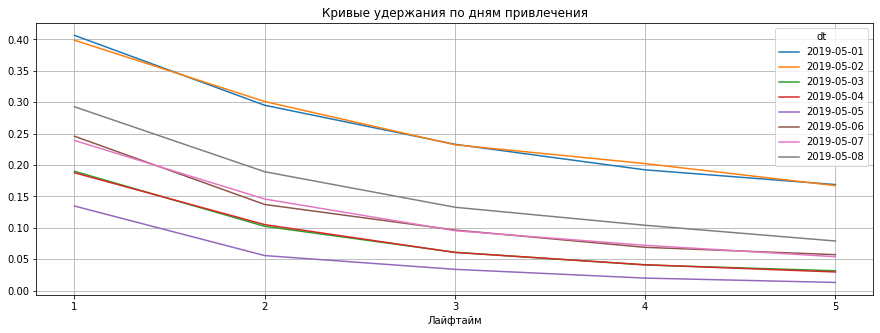

In [8]:
# строим кривые удержания

report = retention.drop(columns = ['cohort_size', 0])

report.T.plot(
    grid=True,  # добавляем сетку
    xticks=list(report.columns.values),  # отметки на оси X — названия колонок
    figsize=(15, 5),  # размер графика
)
plt.xlabel('Лайфтайм')  # название оси X
plt.title('Кривые удержания по дням привлечения')  # название графика
plt.show()

Кривые удержания вторят хитмэпу: самый высокий коэффициент удержания — у когорт 1 и 2 мая, а худший результат показывает когорта привлечённых 5 мая. 

Детальнее сравнить показатели когорт график не позволяет — линии сливаются. Особенно это заметно на шестом дне: выявить лидера очень трудно, хотя по хитмэпу мы знаем, что удержание первой когорты немного выше.

#### Удержание в динамике

Если задача — проанализировать, как менялось удержание от когорты к когорте для каждого дня «жизни» пользователей, подойдёт график истории изменений.

Построить такой график проще всего — достаточно вызвать `plot()` к таблице удержания. Без всякого транспонирования.

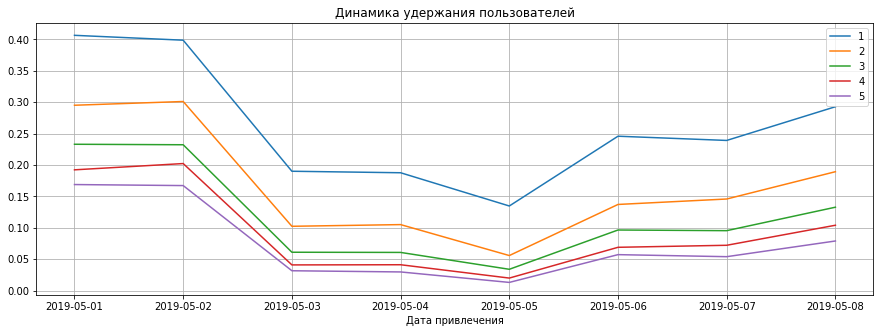

In [9]:
# строим графики изменений

report = retention.drop(columns=['cohort_size', 0])

report.plot(grid=True, figsize=(15, 5))
plt.xlabel('Дата привлечения')
plt.title('Динамика удержания пользователей')
plt.show()

Каждая линия на этом графике показывает, как менялось удержание пользователей на определённый лайфтайм. Например, синяя линия сверху отражает изменения в удержании второго дня, или первого лайфтайма, а нижняя фиолетовая — в удержании шестого дня.

По графику изменений хорошо видно, что удержание второго дня резко упало для когорт, привлечённых после 2 мая. Зато 5 мая началось восстановление.